In [35]:
import torch
import math
import numpy as np
import os
from natsort import natsorted
import matplotlib.pyplot as plt
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
from torch.nn.utils import clip_grad_value_
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from scipy.ndimage import zoom
from glob import glob
import nibabel as nib
from tqdm import tqdm
import cv2
import torch.nn.functional as F


# outline for gradcam
- set hook that gets the gradients for the last layer of the feature extractor
- get outputs of the last layer of the feature extractor which are the activations
- multiply the activations by the gradients
- do the necessary steps to make the maps fit the original image


In [16]:
class VGG(nn.Module):
    def __init__(self, feature_extractor):
        super(VGG, self).__init__()
        self.feature_extractor = feature_extractor

        self.T1_feature_dimension = 64* 64 *3 #1 * 128 * 6 * 6 * 6 # raw T1 data 200*200*200
        
        feature_dimension = self.T1_feature_dimension

        self.classifier = nn.Sequential(
            nn.Dropout(), # commented on 20201230
            nn.Linear(feature_dimension, 1024), #nn.Linear(feature_dimension, 2048),
            nn.ReLU(True),

            nn.Dropout(),
            nn.Linear(1024, 128), #nn.Linear(2048, 512),
            nn.Sigmoid(),
            nn.Linear(128, 2), #nn.Linear(512, 2),
        )

         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activation_gradient(self):
        return self.gradients
    
    def get_activations(self, x1):
        x1 = self.feature_extractor(x1)
        return x1

    def forward(self, x1):
        x1 = self.feature_extractor(x1)
        h = x1.register_hook(self.activations_hook)
        x = x1.view(x1.size(0), -1)

        x = self.classifier(x)
        return x

# 5-27-2021
class SE_block(nn.Module):
    se_ratio = 16
    def __init__(self,ch,ratio=se_ratio):
        super(SE_block, self).__init__()

        # Both should use the same complex number for initiaization which is then split into real and imaginary parts
        # Weight initialiation using the real part 
        self.globalpooling = nn.AdaptiveAvgPool3d(1)
        # Weight initialization using the imag part
        self.linear1 = nn.Linear(ch,ch//ratio)
        self.relu1 = nn.ReLU()
        self.lienar2 = nn.Linear(ch//ratio,ch)
        self.sigmoid1 = nn.Sigmoid()
        self.ch = ch

    def forward(self, x):
        x_init=x
        x1=self.globalpooling(x).squeeze()
        x1=self.linear1(x1)
        x1=self.relu1(x1)
        x1=self.lienar2(x1)
        x1=self.sigmoid1(x1).reshape(x.shape[0],self.ch,1,1,1)

        return torch.mul(x_init,x1)


def make_layers(cfg, batch_norm=True, se_block=True):
    layers = []
    DropoutRate = 0.10

    in_channels = 1

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool3d(kernel_size=2, stride=2)] # MaxPool without Dropout # commented on 20201230
            #layers += [nn.Dropout(p=DropoutRate), nn.MaxPool3d(kernel_size=2, stride=2)] # MaxPool with Dropout rate of 0.25 # commented on 20201230
        else:
            if batch_norm:
                if se_block:
                    conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
                    se3d = SE_block(ch=v)
                    layers += [conv3d, nn.BatchNorm3d(v), se3d, nn.ReLU(inplace=True)]
                else:
                    conv3d = nn.Conv3d(in_channels, v, kernel_size=3, padding=1)
                    layers += [conv3d, nn.BatchNorm3d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv3d, nn.ReLU(inplace=True)]
            in_channels = v
    feature_extractor_T1 = nn.Sequential(*layers)

    return feature_extractor_T1 

cfg = {
    'A': [16, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M', 128, 128], #'A': [32, 'M', 64, 'M', 64, 64, 'M', 128, 128, 'M', 256, 256, 'M'], 
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [16, 16, 'M', 32, 32, 'M', 64, 64, 64, 64, 'M', 128, 128, 128, 128, 'M', 
          128, 128, 128, 128, 'M'],
    'F': [32, 'M', 128, 'M', 512, 'M'],
}

def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E']))

def vgg16_bn():
    """VGG 16-layer model (configuration 'D') with batch normalization"""
    return VGG(make_layers(cfg['D']))

def vgg11_bn():
    """VGG 11-layer model (configuration 'A') with batch normalization"""
    return VGG(make_layers(cfg['A']))

def vgg6_bn():
    """VGG 8-layer model (configuration 'F') with batch normalization"""
    return VGG(make_layers(cfg['F']))

In [17]:
model = vgg11_bn()

In [18]:
def downsize_transform(data): 
    target_size = (64, 96, 64)
    data = torch.from_numpy(data).unsqueeze(0).unsqueeze(0)
    downsampled = torch.nn.functional.interpolate(data, size=target_size, mode='trilinear')

    return downsampled.squeeze(0)

class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.cn_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/CN")
        self.scz_dir = os.path.join(self.root_dir, "MNI152_affine_WB_iso1mm/schiz")
        self.samples, self.labels = self._load_samples()

    def _load_samples(self):
        samples = []
        
        samples = [file for file in os.listdir(self.cn_dir) if file.endswith(".nii.gz")]
        labels = [0] * len(samples)
        samples += [file for file in os.listdir(self.scz_dir) if file.endswith(".nii.gz")]
        labels += [1] * (len(samples) - len(labels))

        return samples, labels

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if label == 0:
            file_path = os.path.join(self.cn_dir, self.samples[idx])
        else:
            file_path = os.path.join(self.scz_dir, self.samples[idx])
        one_hot_label = torch.zeros(2)
        one_hot_label[label] = 1
        label = one_hot_label

        # Load the NIfTI image
        img = nib.load(file_path)

        # Get the image data array
        img_data = np.float32(img.get_fdata())[0:192, :, 0:192]
        if self.transforms:
            img_tensor = self.transforms(img_data)
        else:
            img_tensor = torch.from_numpy(img_data).unsqueeze(0)
        return img_tensor, label

In [19]:
root_dir = '/home/ljd2160/research/youzhi/test/sample_data/data' #"/media/youzhi/SSD/bme_project/data"
folds_dir = [dir for dir in os.listdir(root_dir) if dir.startswith("fold")]
folds_dir = [os.path.join(root_dir, dir) for dir in folds_dir]
folds_dir = natsorted(folds_dir)
folds_dir

['/home/ljd2160/research/youzhi/test/sample_data/data/fold1',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold2',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold3',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold4',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold5',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold6',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold7',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold8',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold9',
 '/home/ljd2160/research/youzhi/test/sample_data/data/fold10']

In [20]:
dataloaders = []
for i in range(len(folds_dir)):
    fold_dir = folds_dir[i]
    dataset = CustomDataset(fold_dir, downsize_transform) #, downsize_transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
    dataloaders.append(dataloader)
    print("fold", i+1, ": ", len(dataset))

fold 1 :  196
fold 2 :  188
fold 3 :  187
fold 4 :  185
fold 5 :  187
fold 6 :  185
fold 7 :  187
fold 8 :  182
fold 9 :  188
fold 10 :  187


In [21]:
sample = next(iter(dataloaders[0]))
plt.imshow(sample[0][0][0][0:64, int(96/2), 0:64], cmap = 'bone')
print(sample[0].shape)
print(sample[0].type)
print(sample[1])
print(sample[1].shape)

NameError: name 'plt' is not defined

In [28]:
def get_feature_map(model, input):
    pred = model(input)

    pred[:, 1].backward()

    gradients = model.get_activation_gradient()

    pooled_gradients = torch.abs(torch.mean(gradients, dim = [0, 2, 3, 4]))

    activations = model.get_activations(input).detach()
    print("shape of activation: ", activations.shape)
    print("shape of gradients: ", gradients.shape)

    for idx in range(128):
        activations[:, idx, :, :, :] *= pooled_gradients[idx]
    heatmap = torch.mean(activations, 1).squeeze()

    heatmap = np.maximum(heatmap, 0)
    print("shape of heatmap: ", heatmap.shape)

    #print(torch.max(heatmap))
    #heatmap = nn.ReLU(heatmap)

    #all_pos = heatmap >= 0

    #if False in all_pos:

    #    print('------Negative numbers exist !')


    heatmap /= torch.max(heatmap)

    resampled_heatmap = zoom(heatmap, tuple(np.array([64, 96, 64]) / np.array(heatmap.shape))) #cubic spline
    #resampled_heatmap = zoom(heatmap, tuple(np.array([200, 200, 200]) / np.array(heatmap.shape)),order=0) # NN
    #resampled_heatmap = zoom(heatmap, tuple(np.array([200, 200, 200]) / np.array(heatmap.shape)),order=1) # bilinear
    return resampled_heatmap


In [22]:
input = sample[0][0].unsqueeze(0)
pred = model(input)
print(pred)
print(pred[:,1])

tensor([[ 0.3458, -0.2129]], grad_fn=<AddmmBackward0>)
tensor([-0.2129], grad_fn=<SelectBackward0>)


In [29]:
heatmap = get_feature_map(model, sample[0][0].unsqueeze(0))

shape of activation:  torch.Size([1, 128, 4, 6, 4])
shape of gradients:  torch.Size([1, 128, 4, 6, 4])
shape of heatmap:  torch.Size([4, 6, 4])


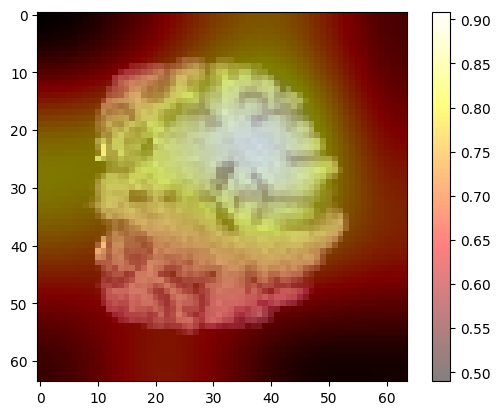

In [58]:

# Assuming heatmap and sample[0] are NumPy arrays
image = sample[0][0][0][0:64, int(96/2), 0:64].numpy()
heatmap_image = heatmap[0:64, int(96/2), 0:64]

# Normalize heatmap values to [0, 255] range
heatmap_normalized = np.uint8(255 * (heatmap_image - np.min(heatmap_image)) / (np.max(heatmap_image) - np.min(heatmap_image)))

# Apply colormap to heatmap
# heatmap_color = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
# # Overlay heatmap on image
# overlaid_image = cv2.addWeighted(image, 0.5, heatmap_color, 0.5, 0)

# # Plot overlaid image
plt.imshow(image, cmap='bone', alpha=1)
plt.imshow(heatmap_image, cmap='hot', alpha=0.5)
plt.colorbar()
# plt.axis('off')
# plt.show()